In [33]:
# Imports

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.arima.model import ARIMA

from typing import List
from typing_extensions import Annotated

import os

In [34]:
# Data Reading

df = pd.read_excel("../data/Registro Público de Emissões.xlsx")

# Data Processing

df = df[df["Escopo"] == "Total"]
df.drop(columns=["Setor da Indústria", "Escopo"], inplace=True)

df = df.transpose()
df.columns = df.iloc[0]
df = df[1:].reset_index()
df = df.rename(columns={"index": "Years"})

list_of_companies = df.columns
list_of_companies = list(list_of_companies)
list_of_companies.remove("Years")

for col in list_of_companies:
    df[col] = df[col].astype(float)
    df[col] = df[col].astype(float)

common_year = 2017
df_filtered = df[df.Years >= common_year]

display(df.head())
display(df.info())


Empresa,Years,Suzano,CSN,Intercement,Ternium Brasil,Votorantim,ArcelorMittal,CBA,ISA Energia
0,2008,1071559.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009,734909.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,1050928.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011,1369237.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012,1355714.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Years           16 non-null     int64  
 1   Suzano          16 non-null     float64
 2   CSN             11 non-null     float64
 3   Intercement     11 non-null     float64
 4   Ternium Brasil  11 non-null     float64
 5   Votorantim      9 non-null      float64
 6   ArcelorMittal   7 non-null      float64
 7   CBA             7 non-null      float64
 8   ISA Energia     7 non-null      float64
dtypes: float64(8), int64(1)
memory usage: 1.3 KB


None

In [35]:
# Auxiliaries Function


def applies_linear_regression(X, y, X_pred):
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    y_pred = model.predict(X_pred.reshape(-1, 1))
    y_pred[y_pred < 0] = 0
    return y_pred


def applies_autoregressive_model(data, p=0, d=0, q=0, steps_for_forec=1):
    model = ARIMA(data, order=(p, d, q)).fit()
    y_pred = model.forecast(steps=steps_for_forec)
    y_pred[y_pred < 0] = 0
    return y_pred


def get_rolling_values(df, company_name, windows=3):
    X_train = df.Years.values
    ser = df.loc[:, company_name]

    X_train = df.Years.values[~np.isnan(ser.values)]
    ser = ser[~np.isnan(ser.values)]

    ser = ser.rolling(windows).mean()

    X_rolling = X_train
    y_rolling = ser.values
    
    X_rolling = X_train[~np.isnan(y_rolling)]
    y_rolling = y_rolling[~np.isnan(y_rolling)]

    return X_rolling, y_rolling


def get_values(df, company_name):
    X_plot = df.Years.values
    y_plot = df.loc[:, company_name].values
    X_plot = X_plot[~np.isnan(y_plot)]
    y_plot = y_plot[~np.isnan(y_plot)]

    return X_plot, y_plot

def set_weights(data, w: list, commom_range_delimiter=5):
    """Set weights for weighted regression."""

    weights = np.ones(len(data))

    weights[:commom_range_delimiter] = w[0]  # past window weight
    weights[commom_range_delimiter:] = w[1]  # common window weight

    return weights


def generate_weight_pairs_matrix(weight_a, weight_b, n):
    """Generate matrix with weight lists [wa, wb], such that wa + wb = 1 for tests."""

    # Matrix Columns
    col2 = np.linspace(weight_a, weight_b, n)
    col1 = 1 - col2

    # Matrix
    weight_pairs = np.column_stack((col1, col2))

    return weight_pairs


def fit_model(
    X,
    y,
    model: str,
    weights: Annotated[List[float], "List of past- and common-windou weights [wp, wc]"],
    commom_range_delimiter
):
    """Select models for weighted regression."""

    # Weights
    weights = set_weights(y, weights, commom_range_delimiter)
    
    # Reshape Input for 2D
    X = X.reshape(-1, 1)

    if model == "poly":
        M = make_pipeline(PolynomialFeatures(degree=4), LinearRegression())
        M.fit(X, y, linearregression__sample_weight=weights)

    elif model == "svr-rbf":
        M = SVR(kernel="rbf")  # ou 'poly' para polinomial
        M.fit(X, y, sample_weight=weights)

    elif model == "svr-poly":
        M = SVR(kernel="poly")  # ou 'poly' para polinomial
        M.fit(X, y, sample_weight=weights)

    elif model == "rf":
        M = RandomForestRegressor(n_estimators=100)
        M.fit(X, y, sample_weight=weights)

    return M
    


Suzano

poly
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [4573828.58203125 4589053.64453125 4436317.9453125  4090455.69921875
 3526264.11328125 2718503.40625    1641896.75      ]

svr-rbf
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [3777426.32095797 3777425.97802319 3777425.54552842 3777425.12844361
 3777424.79043828 3777424.55179382 3777424.40240283]

svr-rbf
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [3954735.1225668  3602264.11895621 3180592.89603385 2765033.2791923
 2405233.62002854 2127491.9006619  1939207.2641189 ]

CSN

poly
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [74862793.3125 74086832.0625 67437728.0625 53819247.5625 32133540.8125
  1281144.8125        0.    ]

svr-rbf
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [51838554.71081683 51838554.10279261 51838553.57582507 51838553.23321848
 51838553.05739047 51838552.98473891 51838552.96035831]

svr-rbf
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [61430879.36375685 5383466

/home/thiagoney/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



Intercement

poly
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [1607898.46386719 1526763.73339844 1353429.16308594 1068131.35449219
  651077.74902344   82446.69433594       0.        ]

svr-rbf
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [1399666.50637875 1399665.97018084 1399665.476061   1399665.14537958
 1399664.97302248 1399664.90118572 1399664.87696001]

svr-rbf
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [1586823.5804981  1535445.47805197 1451310.34711961 1370947.99254753
 1328692.39925704 1342022.18167677 1404348.11092247]

Ternium Brasil

poly
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [14762697.765625 17759178.640625 21915335.828125 27404368.078125
 34399729.078125 43075126.921875 53604524.765625]

svr-rbf
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [11429446.14011759 11429446.12634572 11429446.02901453 11429445.92567887
 11429445.85553441 11429445.82036633 11429445.80672693]

svr-rbf
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_p

/home/thiagoney/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



ArcelorMittal

poly
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [3.84006809e+07 4.96077730e+07 6.36780882e+07 8.08655936e+07
 1.01424628e+08 1.25609901e+08 1.53676496e+08]

svr-rbf
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [18522946.60707791 18522945.93912105 18522945.61150426 18522945.5168671
 18522945.50039164 18522945.49865443 18522945.49854337]

svr-rbf
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [24814674.89765271 21138576.66242626 17356602.60857417 15996656.28130578
 17236618.75704783 19485336.15856405 20958663.02608978]


/home/thiagoney/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



CBA

poly
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [462644.9375      0.          0.          0.          0.          0.
      0.    ]

svr-rbf
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [2899655.23501872 2899654.5523194  2899654.22307638 2899654.12833245
 2899654.11185278 2899654.11011548 2899654.11000441]

svr-rbf
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [2891428.55962928 2296839.07420478 2027228.83943833 2277186.19314413
 2847890.37019849 3304811.58406244 3308367.85528219]

ISA Energia

poly
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [0. 0. 0. 0. 0. 0. 0.]

svr-rbf
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [10868624.39481934 10868624.92098173 10868625.22073983 10868625.31223128
 10868625.32849743 10868625.33022632 10868625.33033719]

svr-rbf
X_pred: [2024 2025 2026 2027 2028 2029 2030]
y_pred: [12505965.58749054 13655295.84974062 11534503.02744655 11237385.21442431
 12224370.22865787 12255463.8683124  11807304.05527556]


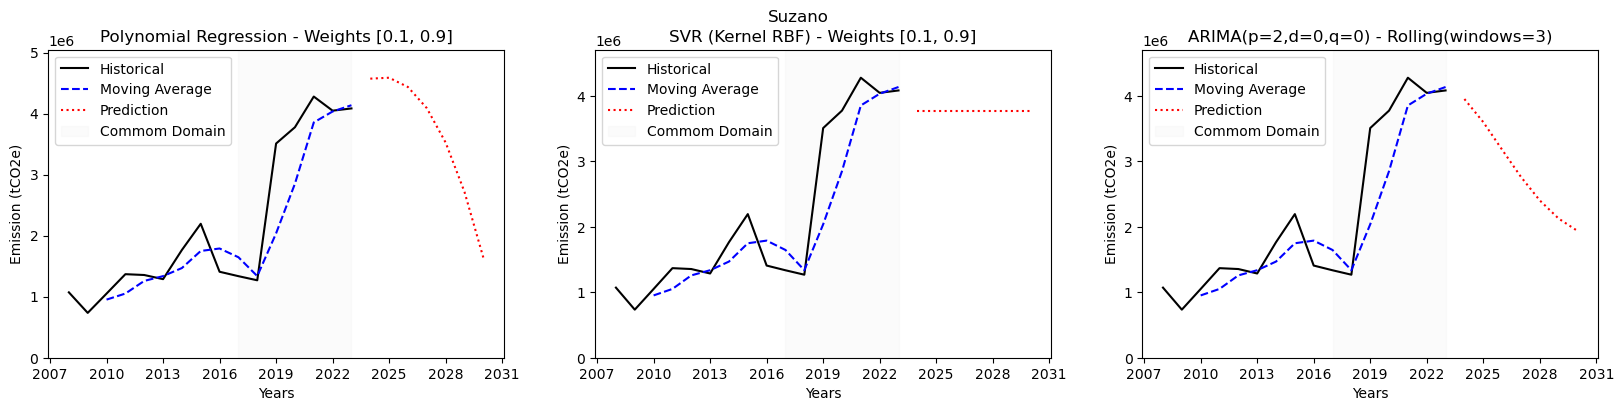

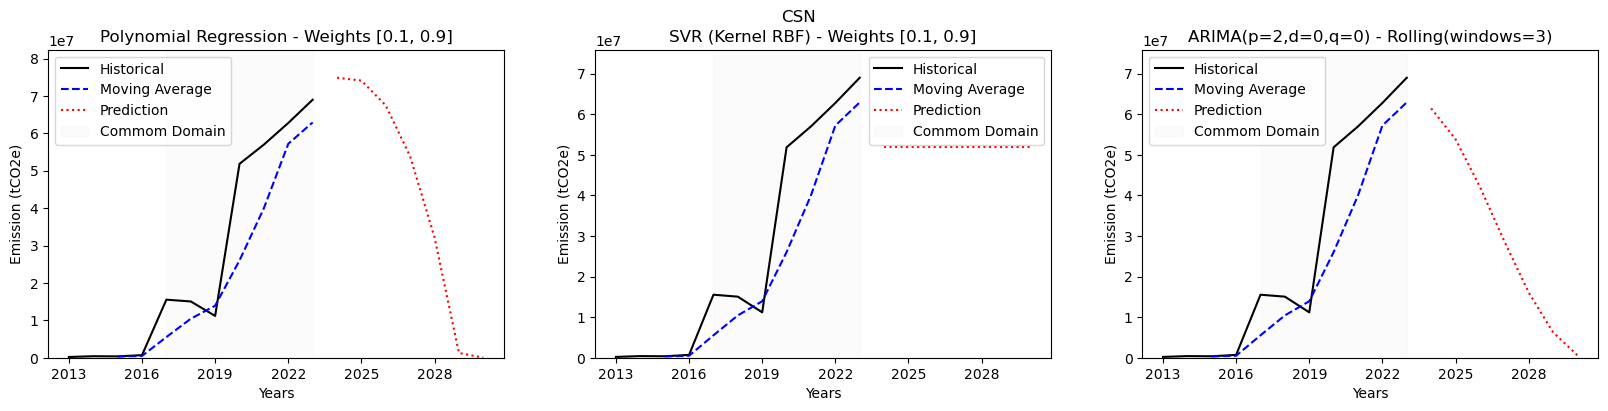

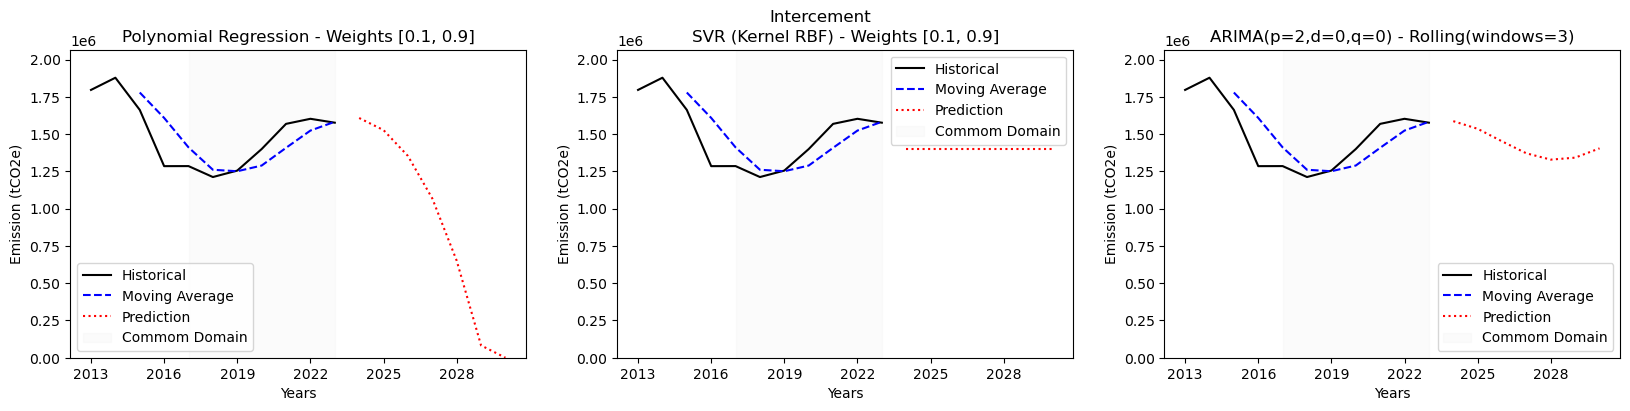

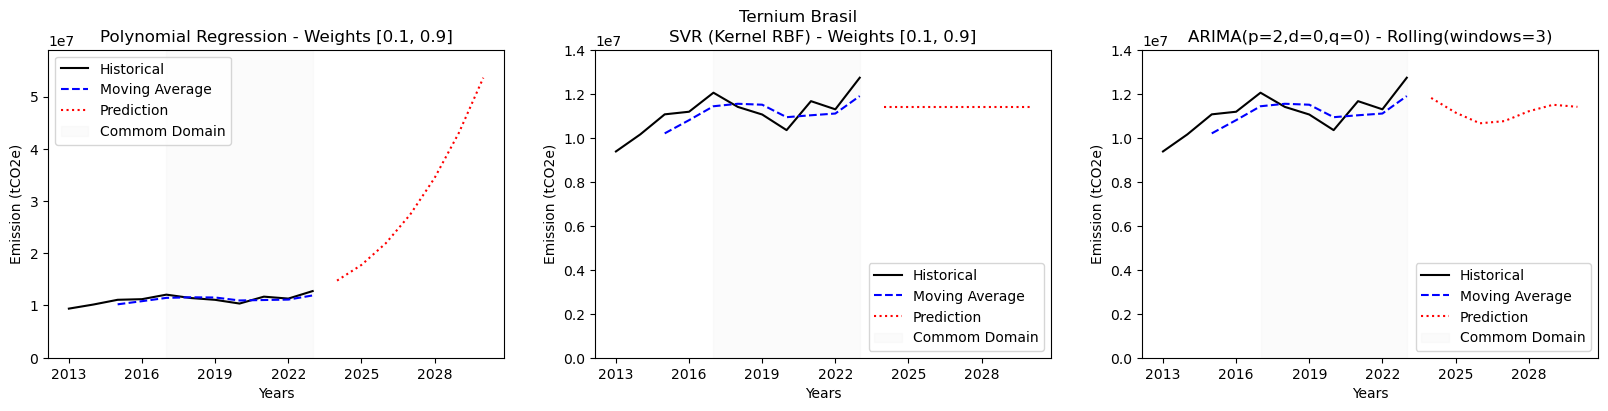

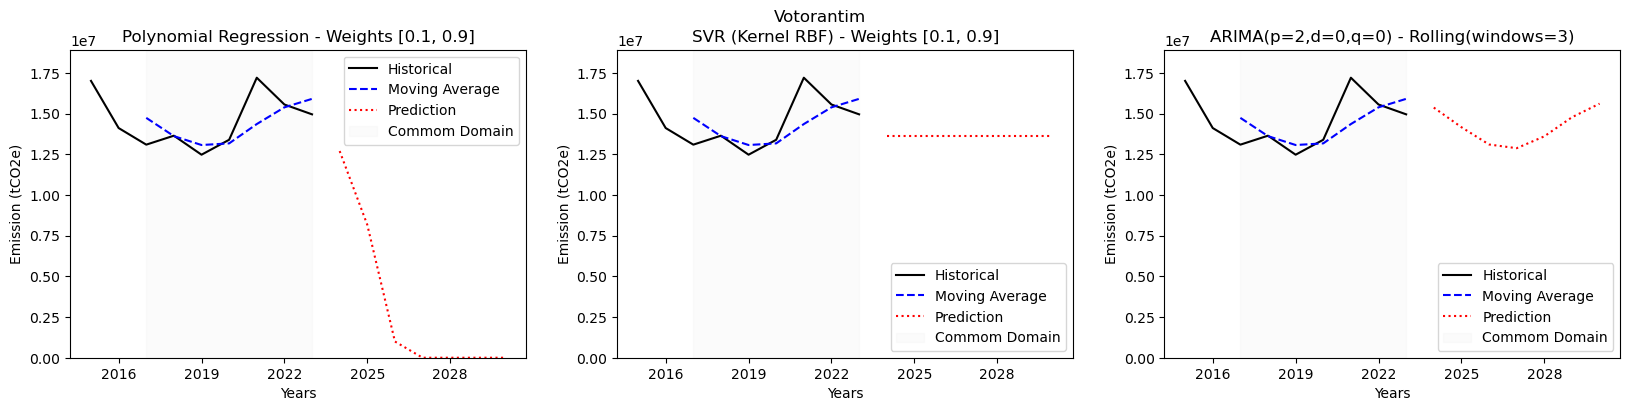

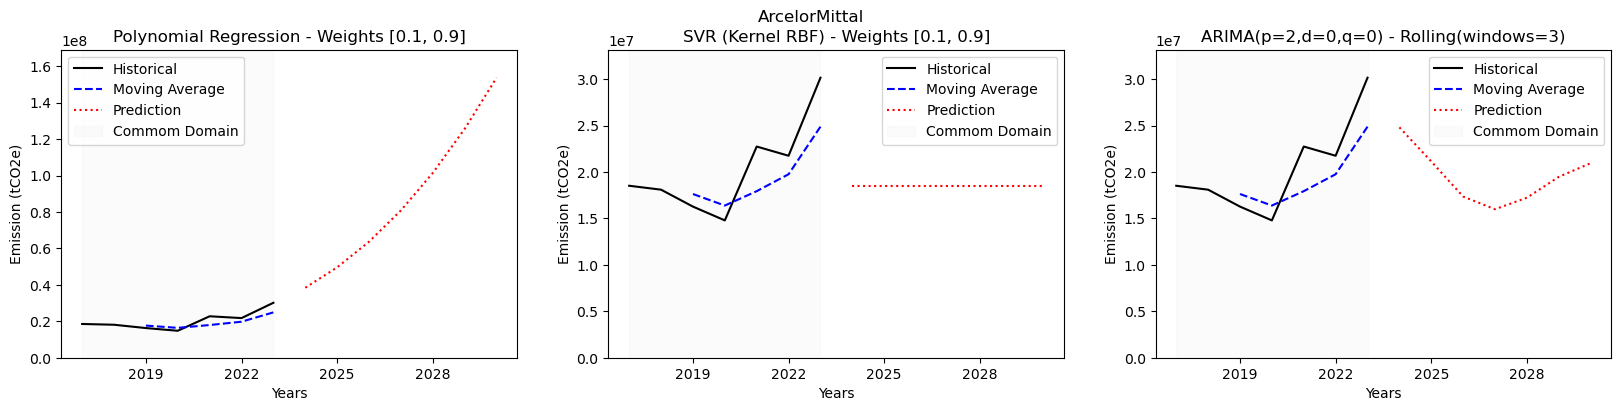

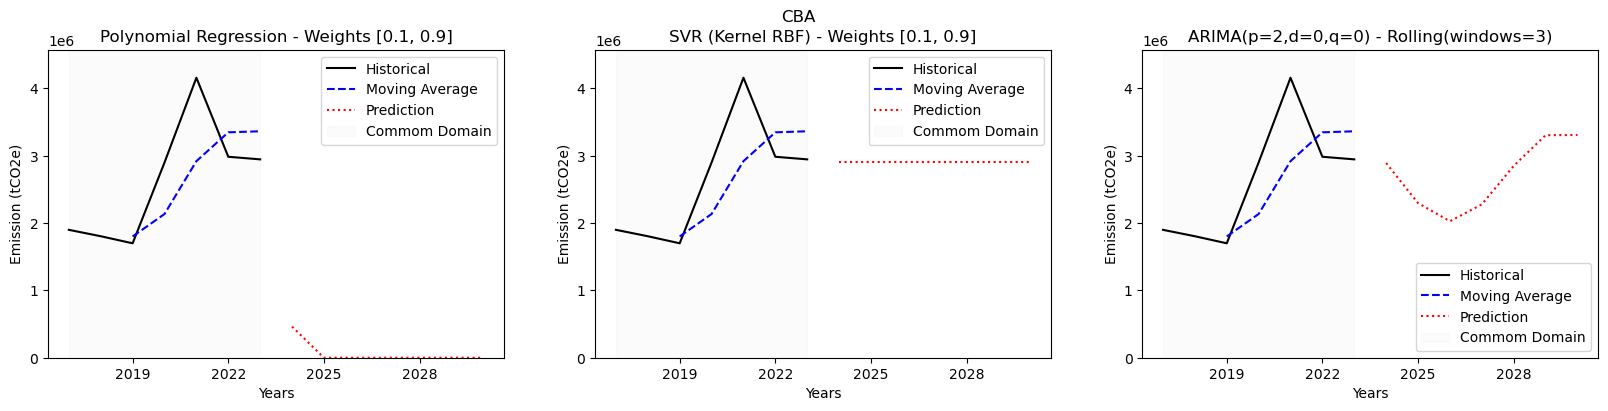

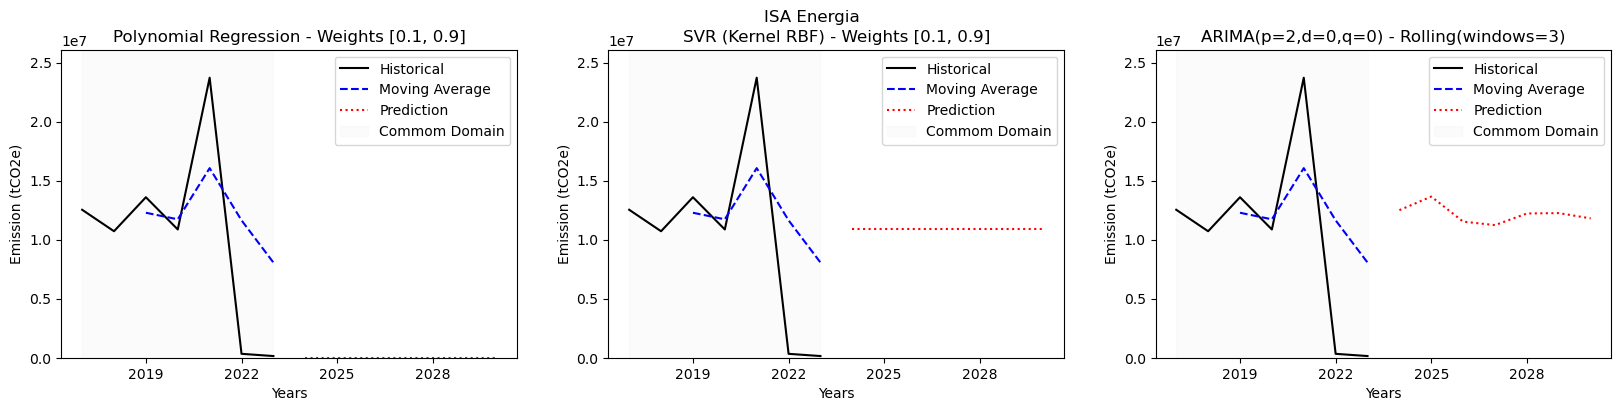

In [ ]:
# Execution

X_pred = np.array(range(2024, 2031))
commom_range = [2017, 2023]
weights = [0.1, 0.9]
windows = 3

for company_name in list_of_companies:
    X_train, y_train = get_values(df, company_name)
    X_rolling, y_rolling = get_rolling_values(df, company_name, windows=windows)
    commom_range_delimiter = np.where(X_train == common_year)[0][0]

    fig, axs = plt.subplots(1, 3, figsize=(20, 4))
    axs = axs.flatten()

    print(f"\n{company_name}")

    # Linear Model
    model = "poly"
    M = fit_model(X_train, y_train, model, weights, commom_range_delimiter)
    y_pred = M.predict(X_pred.reshape(-1, 1))
    y_pred[y_pred < 0] = 0

    ax = axs[0]
    ax.plot(X_train, y_train, "k", label="Historical")
    ax.plot(X_rolling, y_rolling, "--b", label="Moving Average (3 Years)")
    ax.plot(X_pred, y_pred, "r:", label="Prediction")
    ax.axvspan(
        commom_range[0],
        commom_range[1],
        color="gray",
        alpha=0.03,
        label="Commom Domain",
    )

    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.set_ylim([0, 1.1 * max(max(y_train), max(y_pred))])
    ax.legend()
    ax.set_xlabel("Years")
    ax.set_ylabel("Emission (tCO2e)")
    ax.set_title(f"Polynomial Regression - Weights [0.1, 0.9]")

    print(f"\n{model}")
    print(f"X_pred: {X_pred}")
    print(f"y_pred: {y_pred}")

    # SVR Model
    model = "svr-rbf"
    M = fit_model(X_train, y_train, model, weights, commom_range_delimiter)
    y_pred = M.predict(X_pred.reshape(-1, 1))
    y_pred[y_pred < 0] = 0

    ax = axs[1]
    ax.plot(X_train, y_train, "k", label="Historical")
    ax.plot(X_rolling, y_rolling, "--b", label="Moving Average (3 Years)")
    ax.plot(X_pred, y_pred, "r:", label="Prediction")
    ax.axvspan(
        commom_range[0],
        commom_range[1],
        color="gray",
        alpha=0.03,
        label="Commom Domain",
    )

    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.set_ylim([0, 1.1 * max(max(y_train), max(y_pred))])
    ax.legend()
    ax.set_xlabel("Years")
    ax.set_ylabel("Emission (tCO2e)")
    ax.set_title(f"SVR (Kernel RBF) - Weights [0.1, 0.9]")

    print(f"\n{model}")
    print(f"X_pred: {X_pred}")
    print(f"y_pred: {y_pred}")

    # ARIMA Model
    p, d, q = 2, 0, 0

    y_pred = applies_autoregressive_model(y_rolling, p, d, q, steps_for_forec=7)

    ax = axs[2]
    ax.plot(X_train, y_train, "k", label="Historical")
    ax.plot(X_rolling, y_rolling, "--b", label="Moving Average (3 Years)")
    ax.plot(X_pred, y_pred, "r:", label="Prediction")
    ax.axvspan(
        commom_range[0],
        commom_range[1],
        color="gray",
        alpha=0.03,
        label="Commom Domain",
    )

    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.set_ylim([0, 1.1 * max(max(y_train), max(y_pred))])
    ax.legend()
    ax.set_xlabel("Years")
    ax.set_ylabel("Emission (tCO2e)")
    ax.set_title(
        f"ARIMA(p={p},d={d},q={q}) - Rolling(windows={windows})"
    )

    print(f"\n{model}")
    print(f"X_pred: {X_pred}")
    print(f"y_pred: {y_pred}")

    fig.suptitle(f"{company_name}")
    fig.savefig(f"../img/Comparation/{company_name}.png")